# SegNet CNN Model

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [ ]:
def Segnet(input_shape, num_classes):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Decoder
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)

    return model

In [ ]:
inputshape = (128, 128, 3)
numclasses = 1

In [ ]:
model = Segnet(inputshape, numclasses)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Getting Train-Valid-Test Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

# TRAIN
trainimageNP = np.load("/content/drive/My Drive/MANDIBLE/train_img.npy")
trainmaskNP = np.load("/content/drive/My Drive/MANDIBLE/train_mask.npy")

# VALID
validimageNP = np.load("/content/drive/My Drive/MANDIBLE/valid_img.npy")
validmaskNP = np.load("/content/drive/My Drive/MANDIBLE/valid_mask.npy")

# TEST
testimageNP = np.load("/content/drive/My Drive/MANDIBLE/test_img.npy")
testmaskNP = np.load("/content/drive/My Drive/MANDIBLE/test_mask.npy")

In [ ]:
print(trainimageNP.shape)
print(trainmaskNP.shape)
print(validimageNP.shape)
print(validmaskNP.shape)
print(testimageNP.shape)
print(testmaskNP.shape)

(1626, 128, 128, 3)
(1626, 128, 128)
(465, 128, 128, 3)
(465, 128, 128)
(233, 128, 128, 3)
(233, 128, 128)


## Epoch Training

In [ ]:
lr = 1e-4
batchSize = 32
epochs = 25

In [ ]:
drive_path = '/content/drive/My Drive/MANDIBLE/models/segnet.keras'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Compile the model
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Calculate steps per epoch and validation steps
stepsPerEpoch = len(trainimageNP) // batchSize
validationSteps = len(validimageNP) // batchSize

# Define callbacks
callbacks = [
    ModelCheckpoint(drive_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")
]

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(trainimageNP, trainmaskNP,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validimageNP, validmaskNP),
                    validation_steps=validationSteps,
                    steps_per_epoch=stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks
                    )

# Record the end time
end_time = time.time()

# Calculate the training duration
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/25
50/50 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8288
Epoch 1: val_loss improved from inf to 0.18251, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 [==============================] - 51s 440ms/step - loss: 0.4318 - accuracy: 0.8288 - val_loss: 0.1825 - val_accuracy: 0.9252 - lr: 1.0000e-04
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9272
Epoch 2: val_loss improved from 0.18251 to 0.11748, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 [==============================] - 26s 287ms/step - loss: 0.1749 - accuracy: 0.9272 - val_loss: 0.1175 - val_accuracy: 0.9504 - lr: 1.0000e-04
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9514
Epoch 3: val_loss improved from 0.11748 to 0.10298, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 [==============================] - 15s 292ms/step - los

## Performance Visualization

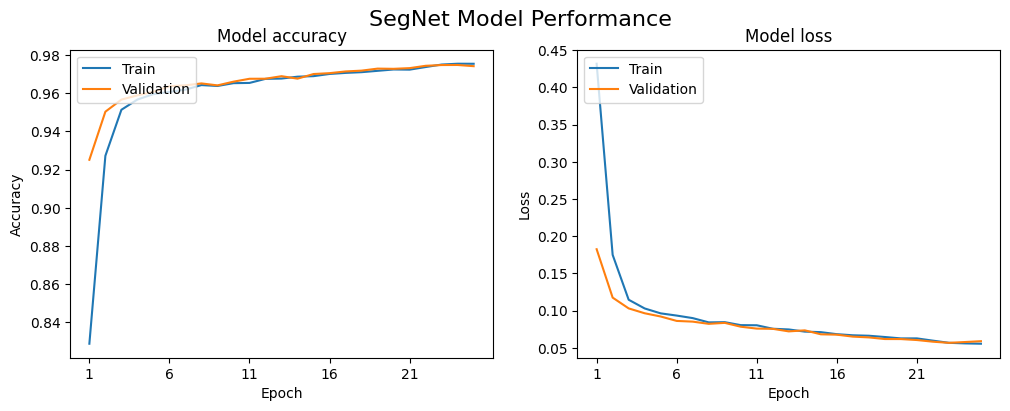

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Determine the number of epochs
epochs = len(history.history['accuracy'])
interval = 5

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

# Add an overall title
plt.suptitle('SegNet Model Performance', fontsize=16)

plt.show()

## Evaluating on Test Set

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(drive_path)

test_loss, test_accuracy = best_model.evaluate(testimageNP, testmaskNP, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 3s 369ms/step - loss: 0.0595 - accuracy: 0.9739
Test Loss: 0.059541553258895874
Test Accuracy: 0.9738549590110779
